In [4]:
from sklearn.datasets import fetch_california_housing

X_full, y_full = fetch_california_housing(return_X_y=True)
n_samples, n_features = X_full.shape

In [22]:
import pandas as pd
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, 
        scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )
)

print(score_full_data)

          0
0 -0.484400
1 -0.622683
2 -0.646209
3 -0.543514
4 -0.494590


In [11]:
import numpy as np

rng = np.random.RandomState(0)

# Add missing value
X_missing = X_full.copy()
y_missing = y_full

missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

In [14]:
# Estimate the score after imputation (mean and median strategies)
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

score_simple_imputer = pd.DataFrame()
for strategy in ('mean', 'median'):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [15]:
score_simple_imputer

,mean,median
0,-0.633233,-0.652143
1,-0.764850,-0.769493
2,-0.810675,-0.812903
3,-0.780172,-0.771061
4,-1.489357,-1.522480


In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import IterativeImputer

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=['Original', 'SimpleImputer', 'IterativeImputer'], axis=1
)

/home/bibagimon/anaconda2/envs/interview/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bibagimon/anaconda2/envs/interview/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bibagimon/anaconda2/envs/interview/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bibagimon/anaconda2/envs/interview/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/bibagimon/anaconda2/envs/interview/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer

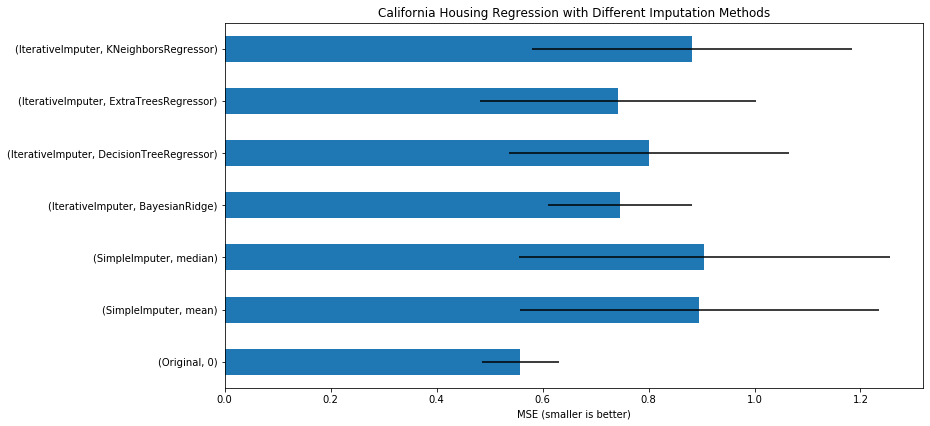

In [30]:
import matplotlib.pyplot as plt

# plot boston results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('California Housing Regression with Different Imputation Methods')
ax.set_xlabel('MSE (smaller is better)')
ax.set_yticks(np.arange(means.shape[0]))
#ax.set_yticklabels([" w/ ".join(label) for label in means.index.get_values()])
plt.tight_layout(pad=1)
plt.show()